### Mining Hydrosaver

[Mining Hyrdrosaver](https://unearthed.solutions/u/competitions/evergreen/hydrosaver) competition dataset from Unearthed Solutions. The purpose is to predict water content in an effluent slurry from a mining facility in Australia. The benefit of predicting mass water fraction 3 hours in advance is that less water can be added to the mining process to save this valuable resource.

This is a sample notebook from [Zachary Hillman](https://www.linkedin.com/in/zachary-hillman-114064171/) where he first predicts the current water content from process parameters. This current prediction is then used with the current process parameters to predict the future water content 3 hours in advance.

Remaining work is to use a time series model such as an LSTM to leverage the trends in the data. Another possible approach is to predict process shutdown (not water content) based on process trends to give early warning of an upset that would lead to lost processing potential.

### Import Packages

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression as LR
# from pandas_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler as SS
from sklearn.preprocessing import MinMaxScaler as MMS
from sklearn.model_selection import train_test_split as TTS
from xgboost import XGBRegressor as xgbr
import xgboost as xgb
from sklearn.metrics import mean_squared_error as mse
import missingno as mso
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neighbors import KNeighborsRegressor as KNN

### Import Data

In [2]:
# get train.csv (158 MB) file with 2 years of 1 minute data from
#   https://unearthed.solutions/u/competitions/evergreen/hydrosaver
data = pd.read_csv('train.csv', parse_dates=['timestamp'])
data.describe(datetime_is_numeric=True)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,22,23,24,28) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,timestamp
count,570300
mean,2015-10-15 23:57:41.867438336
min,2015-04-01 00:00:00
25%,2015-07-08 23:14:45
50%,2015-10-16 00:29:30
75%,2016-01-23 00:44:15
max,2016-04-30 23:59:00


### Find and Remove Empty Columns

In [3]:
check = ['FV88156.PV','FV88043.PV','FV88044.PV','II88151.PV','II88152.PV']
for val in check:
    print(np.unique(data[val]))
data2 = data.drop(check,axis=1)
data2.head()

['No Data']
['No Data']
['No Data']
['No Data']
['No Data']


,timestamp,WQI8100XCL1.CPV,XI84201.PV,XI84202.PV,XI84123.PV,XI84124.PV,XI84125.PV,FX87211.CPV1,FIC87211.PV,FIC87211.SV,...,NIC88002.PV,PIC88007.PV,LIC88006.PV,AIC88055.PV,FIC88022.PV,DIC88023.PV,SI88033.PV,SI88034.PV,MQI88024.CPV,target
0,2015-04-01 00:00:00,741.9462,101.188,82.2091,0.0625,5.72497,26.7562,747.1719,4226.19,4190.6,...,32.2354,12.7003,42.6176,-0.002185,812.194,55.3623,0.081598,71.8973,697.8384,56.0887
1,2015-04-01 00:01:00,746.5532,103.251,81.4628,0.0625,5.72497,26.7562,746.348,4205.333,4189.08,...,32.2146,12.8188,42.80501,-0.00246,811.2485,55.3483,0.082387,71.5966,697.2875,56.0813
2,2015-04-01 00:02:00,731.2003,103.803,81.3842,0.0625,5.72497,26.7562,745.524,4211.97,4185.91,...,32.2152,12.86702,43.02822,-0.002734,807.9185,55.34222,0.080556,71.71885,694.1823,56.0751
3,2015-04-01 00:03:00,736.6832,104.336,81.2412,0.065576,5.61836,26.3297,744.6599,4155.305,4182.59,...,32.2838,12.87484,43.25486,-0.003009,808.6615,55.3453,0.080768,71.6621,694.5441,56.08075
4,2015-04-01 00:04:00,732.5973,106.718,80.5021,0.065576,5.60313,25.9048,743.7692,4161.92,4179.06,...,32.30124,12.8809,43.46781,-0.003284,807.0225,55.33858,0.080637,71.7182,693.4581,56.08325


### Replace Bad Values with `NaN`

In [4]:
tnot = data2.columns[1:]
for i in range(len(tnot)):
    data2[tnot[i]]=data2[tnot[i]].replace(['No Data','I/O Timeout','Bad Input', 'Scan Off'], np.nan)
data2[tnot] = data2[tnot].astype('float64')

### Sort by Time Index and Find Missing Row Values

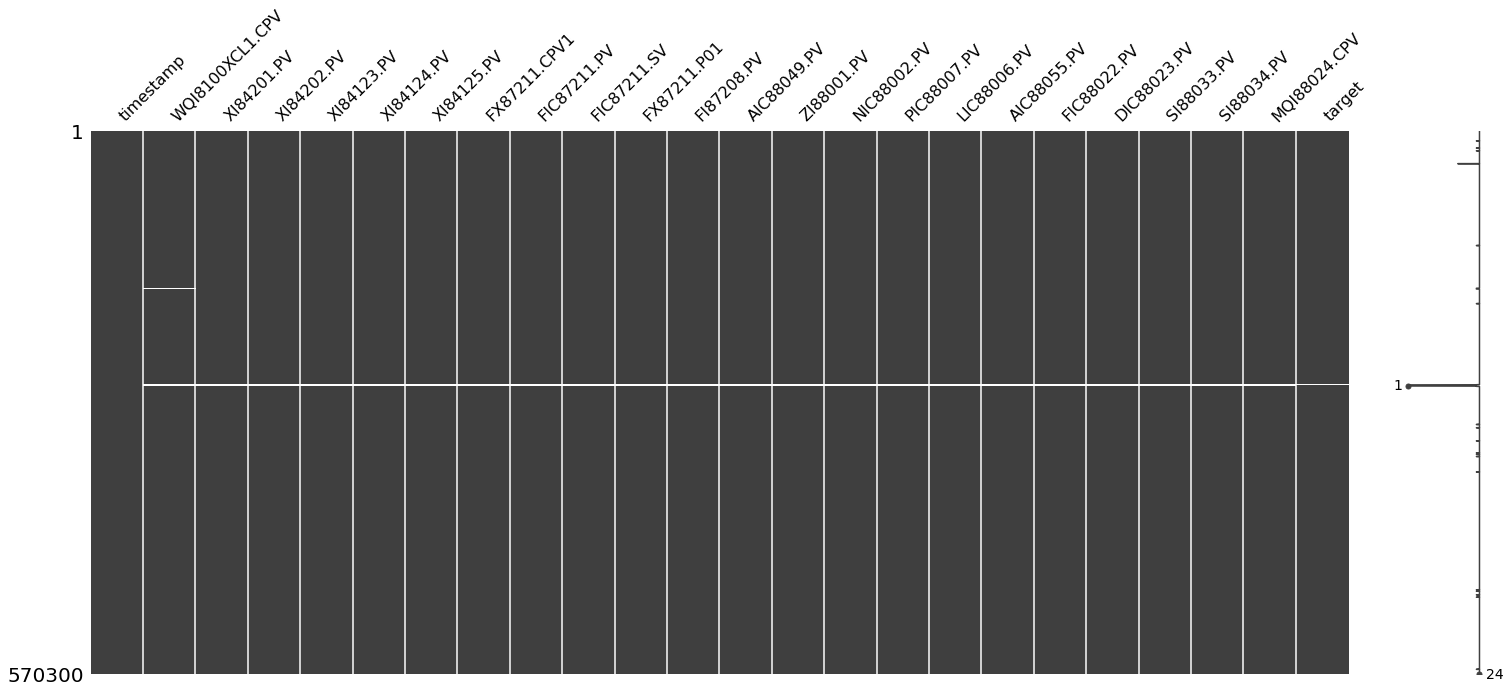

2.0812500000000003


In [5]:
data3 = data2.sort_values('timestamp')
mso.matrix(data3)
plt.show()
print((data3.shape[0]-data3.dropna().shape[0])/60/24) # days missing

### View Time Series Data of Target Water Mass Percent

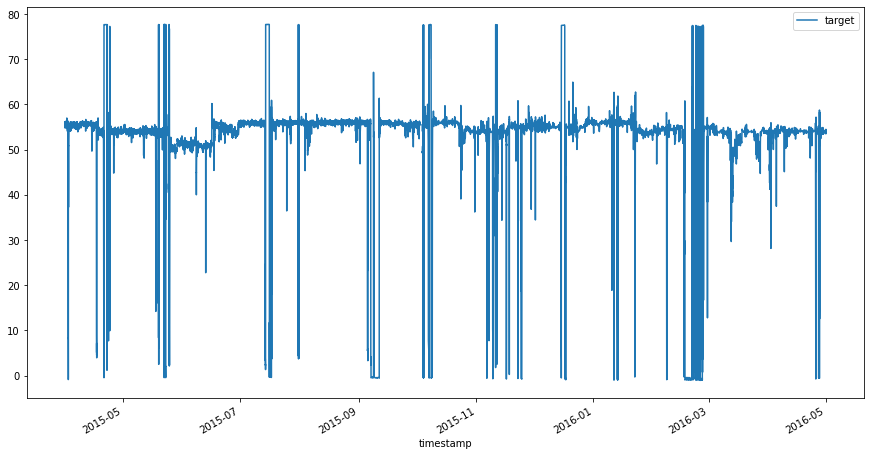

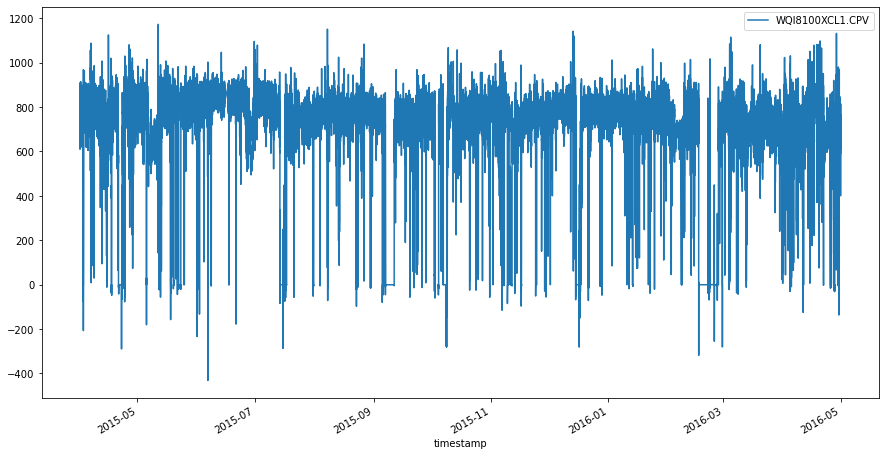

In [6]:
# fig = plt.figure(figsize=(10,15))
data3.plot(x='timestamp',y=['target'], figsize=(15,8))
plt.show()
data3.plot(x='timestamp',y='WQI8100XCL1.CPV',figsize=(15,8))
plt.show()

### Remove Zero Water Mass Fraction

In [7]:
current = 'DIC88023.PV'

data31 = data3.dropna()
data4 = data31.set_index('timestamp')
data5 = data4[(data4['target']>0) & (data4[current]>0)]
# data4.target[0:1000]

### Remove Shutdown Data (<=600)

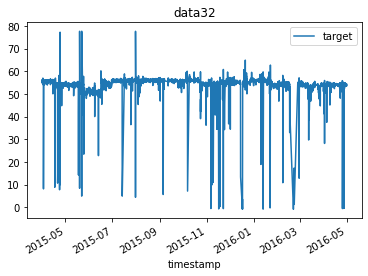

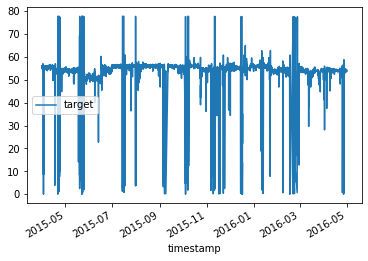

In [8]:
data32 = data3[data3['WQI8100XCL1.CPV']>600]
data33 = data32.set_index('timestamp')
data33.plot(y='target')
plt.title('data32')
plt.show()
data5.plot(y='target')
plt.show()

### Step 1: Predicting Current Water Mass Fraction

### Find Best Features

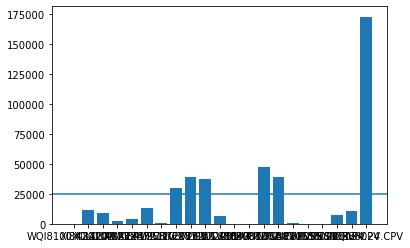

FIC87211.PV 29995.278238263458
FIC87211.SV 39292.47712679547
FX87211.P01 37579.72268245109
NIC88002.PV 47720.52871053226
PIC88007.PV 38616.64668378912
MQI88024.CPV 172622.03662483927


In [9]:
dfusep = data33.copy() #data5
dfuse = dfusep.dropna()
threshold = 25000
feat = list(dfuse.columns)
feat.remove(current)
feat.remove('target')
best = SelectKBest(score_func=f_regression, k='all')
fit = best.fit(dfuse[feat],dfuse[current])
plt.bar(x=dfuse[feat].columns, height=fit.scores_)
plt.axhline(y=threshold)
plt.show()
betters = []
for i,h in enumerate(fit.scores_):
    if h> threshold:
        betters.append(feat[i])
        print(feat[i], h)

### Train Using the 6 Best Features

In [10]:
# Train with unscaled data
Xtrain,Xtest, ytrain,ytest = TTS(dfuse[betters],dfuse[current], test_size = .2, random_state=47)
mod = xgbr()
mod.fit(Xtrain,ytrain)
mod2 = xgbr()
s = SS()

# Train with scaled data
#  Note: not needed here because decision trees work
#        the same on scaled versus unscaled data
Xtrains = s.fit_transform(Xtrain)
Xtests = s.transform(Xtest)
mod2.fit(Xtrains,ytrain)
pass

### Visualize the Unscaled Predictions

0.668


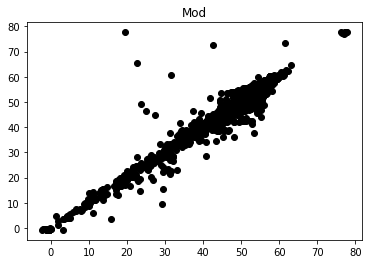

In [11]:
pr = mod.predict(Xtest)
# pr2 = mod2.predict(Xtests)
# pr3 = mod3.predict(Xtests)
# pr4 = mod4.predict(xgb.DMatrix(Xtest))
print(format(mse(pr,ytest,squared=False),'.3g'))
plt.plot(pr,ytest, 'ko')
plt.title('Mod')
plt.show()

### Step 2: Predict Water Mass Percent 3 Hours in Future

- Create xgbr model that predicts 3 hours using the current prediction and current process parameters as an input

### Check for No Time Gaps / Continuous Data

In [13]:
dfut = data3.copy().head(int(data3.shape[0]*.25))
# check continuity 
print(dfut.timestamp.isna().sum())
dfut['tDiff'] = dfut.timestamp.diff()
dfut[dfut.tDiff > pd.Timedelta('1m')]

0


,timestamp,WQI8100XCL1.CPV,XI84201.PV,XI84202.PV,XI84123.PV,XI84124.PV,XI84125.PV,FX87211.CPV1,FIC87211.PV,FIC87211.SV,...,PIC88007.PV,LIC88006.PV,AIC88055.PV,FIC88022.PV,DIC88023.PV,SI88033.PV,SI88034.PV,MQI88024.CPV,target,tDiff


### Don't Use Process Variables During a Shutdown Now and +3 Hrs

In [16]:
offs = 'WQI8100XCL1.CPV'
dfut3['fix'] = dfut3[offs].shift(-60*3)
dfut4 = dfut3[(dfut3[offs]>600) & (dfut3.fix > 600)]
dfut4.shape

(124412, 26)

### Find New Best Features for Water Percent at 3 Hrs

['WQI8100XCL1.CPV', 'XI84201.PV', 'XI84202.PV', 'XI84123.PV', 'XI84124.PV', 'XI84125.PV', 'FX87211.CPV1', 'FIC87211.PV', 'FIC87211.SV', 'FX87211.P01', 'FI87208.PV', 'AIC88049.PV', 'ZI88001.PV', 'NIC88002.PV', 'PIC88007.PV', 'LIC88006.PV', 'AIC88055.PV', 'FIC88022.PV', 'DIC88023.PV', 'SI88033.PV', 'SI88034.PV', 'MQI88024.CPV', 'target']


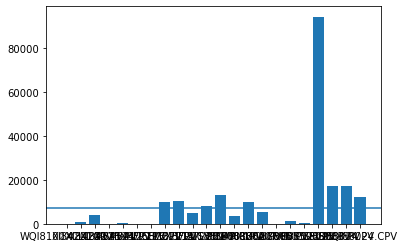

FIC87211.PV 9984.866444861815
FIC87211.SV 10474.84977247352
FI87208.PV 8055.685745454605
AIC88049.PV 13227.28195153755
NIC88002.PV 9927.806443522206
DIC88023.PV 94155.58152724248
SI88033.PV 17025.544528644914
SI88034.PV 17272.226957994706
MQI88024.CPV 12364.33378643162


In [17]:
dfutuse = dfut4.copy()
betf = betters.copy()
betf.append(current)
feat2 = feat.copy()
feat2.append(current)
Xtrain2,Xtest2, ytrain2,ytest2 = TTS(dfutuse[feat2],dfutuse['target'], test_size = .2, random_state=47)
# Xtrain['pred'] = mod.predict(Xtrain)
threshold = 7_000
feat3 = list(dfutuse.columns)
feat3 = feat3[:-3]
print(feat3)
# feat.remove(current)
feat3.remove('target')
best = SelectKBest(score_func=f_regression, k='all')
fit = best.fit(dfutuse[feat3],dfutuse['target'])
plt.bar(x=dfutuse[feat3].columns, height=fit.scores_)
plt.axhline(y=threshold)
plt.show()
betters2 = []
for i,h in enumerate(fit.scores_):
    if h> threshold:
        betters2.append(feat3[i])
        print(feat3[i], h)

### XBoost Training

In [18]:
fut = xgbr()
fut.fit(Xtrain2[betters2],ytrain2)
pass

### XGBoost Predict and Plot with Test Data

- Replace Measured Current Water Percent with Predicted Current Water Percent
- Evaluate Based on Predicted Intermediate Value

0.803


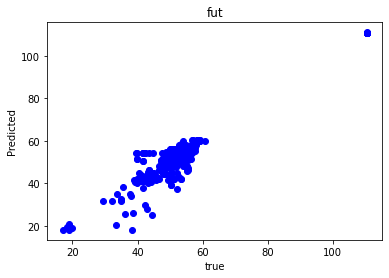

In [20]:
Xtest2[current] = mod.predict(Xtest2[betf].drop(current,axis=1))
# Xtest = Xtest.drop(current, axis=1)
prf = fut.predict(Xtest2[betters2])
print(format(mse(prf,ytest2,squared=False),'.3g'))
plt.plot(prf,ytest2, 'bo')
plt.xlabel('true')
plt.ylabel('Predicted')
plt.title('fut')
plt.show()

### K-Nearest Neighbors Training and Testing

In [19]:
kn = KNN()
kn.fit(Xtrain2[betters2],ytrain2)
pass

0.95


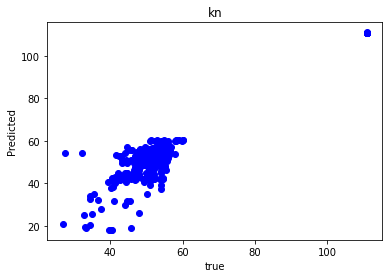

In [21]:
Xtest2[current] = mod.predict(Xtest2[betf].drop(current,axis=1))
# Xtest = Xtest.drop(current, axis=1)
prf = kn.predict(Xtest2[betters2])
print(format(mse(prf,ytest2,squared=False),'.3g'))
plt.plot(prf,ytest2, 'bo')
plt.xlabel('true')
plt.ylabel('Predicted')
plt.title('kn')
plt.show()

### Test on the Remainder of the Data (Train, Validate, Test)

In [22]:
dtest = data3.copy().tail(int(data3.shape[0]*.75))
dtest2 = dtest.set_index('timestamp')
dtest3 = dtest2.resample('1min').sum()
offs = 'WQI8100XCL1.CPV'
dtest3['fix'] = dtest3[offs].shift(-60*3)
dtest4 = dtest3[(dtest3.fix > 600) & (dtest3[offs] > 600)]

dtest4[current] = mod.predict(dtest4[betf].drop(current,axis=1))
dtest4['pred'] = fut.predict(dtest4[betters2])

# dfut3[dfut3.tDiff > pd.Timedelta('1m')]
#succesfully fixed gap

<ipython-input-22-7d871ed3009a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtest4[current] = mod.predict(dtest4[betf].drop(current,axis=1))
<ipython-input-22-7d871ed3009a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtest4['pred'] = fut.predict(dtest4[betters2])


### Plot of Predictions

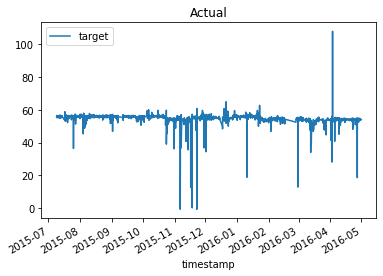

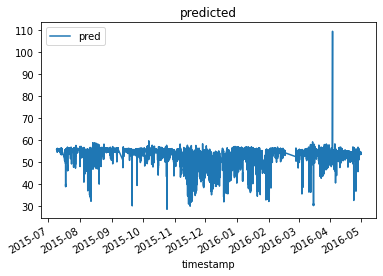

4.09


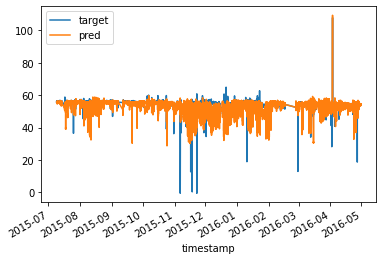

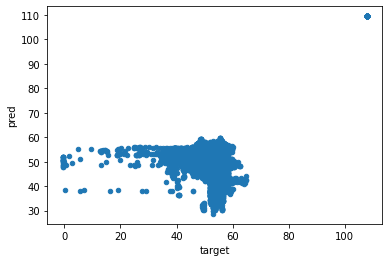

In [23]:
dtest4.plot(y='target')
plt.title('Actual')
plt.show()
dtest4.plot(y='pred')
plt.title('predicted')
plt.show()
dtest4.plot(y=['target','pred'])
print(format(mse(dtest4['pred'],dtest4['target'],squared=False),'.3g'))
plt.show()
dtest4.plot(x='target',y='pred', marker='o',kind='scatter')
plt.show()

In [25]:
mod.save_model('predict_current.model')
fut.save_model('predict_future.model')